In [1]:
import os
import sys

#------------------------------------------------------------------------------------
# Here is the setting that enable the GPU in this virtual env. You can ignore it or even comment out if there's no any issue when accessing the GPU.

# 1. Define the correct path to the parent directory of 'nvvm' within your venv
# This path points to the 'cuda_nvcc' folder which contains 'nvvm'
NVVM_ROOT_PATH = "/home/haoyu/114-1_DL_final/.venv/lib/python3.10/site-packages/nvidia/cuda_nvcc/"
XLA_FLAGS="--xla_gpu_cuda_data_dir=/usr/lib/cuda"
# 2. Set the environment variable
os.environ['NVVM_ROOT'] = NVVM_ROOT_PATH
os.environ['XLA_FLAGS'] = XLA_FLAGS

# 3. (Optional but helpful) Set LD_LIBRARY_PATH if it wasn't already set correctly
# This is a general safety measure for WSL setups
if "/usr/lib/wsl/lib" not in os.environ.get('LD_LIBRARY_PATH', ''):
    os.environ['LD_LIBRARY_PATH'] = f"/usr/lib/wsl/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"

print("Environment variables set for CUDA path resolution.")
print(f"Python executable: {sys.executable}")

from tensorflow.keras import mixed_precision

# Set the global policy to 'mixed_float16'
# This automatically casts most layers to float16, while keeping key ops (like loss) in float32.
mixed_precision.set_global_policy('mixed_float16')

#------------------------------------------------------------------------------------

path = "/home/haoyu/114-1_DL_final/data/archive/MultiCancer/MultiCancer"
print("資料夾內容:", os.listdir(path))
directory = os.path.join(path, "MultiCancer", "MultiCancer")
# 再次確認最終路徑是否存在
if os.path.exists(directory):
    print(f"成功鎖定資料集路徑: {directory}")
    print("內部檔案:", os.listdir(directory)) # 只列出前5個檔案檢查
else:
    print(f"路徑錯誤，請檢查上面的 '資料夾內容' 來調整 os.path.join")



Environment variables set for CUDA path resolution.
Python executable: /home/haoyu/114-1_DL_final/.venv/bin/python


2025-12-12 20:37:40.074055: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-12 20:37:40.480535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-12 20:37:41.679974: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


資料夾內容: ['CervicalCancer', 'ALL', 'Lymphoma', 'OralCancer', 'KidneyCancer', 'Mixed', 'BreastCancer', 'LungAndColonCancer', 'BrainCancer']
路徑錯誤，請檢查上面的 '資料夾內容' 來調整 os.path.join


In [2]:
import glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

# --- Configuration (UPDATE THIS PATH!) ---
# This directory MUST contain the 26 subclass folders (e.g., 'lymph_cll', 'brain_glioma', etc.)
DATA_DIR = "/home/haoyu/114-1_DL_final/data/archive/MultiCancer/MultiCancer/Mixed" 

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
TEST_SIZE = 0.15 
VAL_SIZE = 0.15 

# --- 1. Collect All Paths and Labels ---
image_paths = []
labels_raw = []
class_to_index = {}
index_to_class = []
index_counter = 0

# Scan directories to map class names to integer indices
for class_folder in sorted(os.listdir(DATA_DIR)):
    class_path = os.path.join(DATA_DIR, class_folder)
    if os.path.isdir(class_path):
        if class_folder not in class_to_index:
            class_to_index[class_folder] = index_counter
            index_to_class.append(class_folder)
            index_counter += 1
            
        current_label_index = class_to_index[class_folder]
        
        # Collect paths and numerical labels
        # Adjust the file extension if your images are not .jpg (e.g., use '*.png')
        for img_file in glob.glob(os.path.join(class_path, '*.jpg')): 
            image_paths.append(img_file)
            labels_raw.append(current_label_index)

NUM_CLASSES = len(index_to_class)
print(f"Total Images: {len(image_paths)}")
print(f"Total Classes Detected: {NUM_CLASSES}")
print(f"Class Names (26 Subclasses): {index_to_class}")


# --- 2. Perform Stratified Split ---
# Split into Training and Temp (30% total)
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, labels_raw, test_size=(TEST_SIZE + VAL_SIZE), random_state=SEED, stratify=labels_raw
)

# Split Temp into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=TEST_SIZE/(TEST_SIZE + VAL_SIZE), random_state=SEED, stratify=y_temp
)

print(f"\nTrain samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


# --- 3. Create TensorFlow Datasets ---

def load_image(file_path, label):
    """Function to load, decode, resize, preprocess, and one-hot encode."""
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) # Cast to float32
    img = preprocess_input(img)     # ResNet50-specific preprocessing (mean subtraction)
    
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return img, label

AUTOTUNE = tf.data.AUTOTUNE

# Create dataset objects from the paths and labels
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Apply loading, shuffling, batching, and prefetching
train_ds = train_ds.map(load_image, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.map(load_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# --- 4. Calculate Class Weights for Imbalance ---
unique_classes = np.unique(y_train)

# Calculate class weights based on the training labels
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)

class_weight_dict = dict(zip(unique_classes, class_weights_array))
print("\nCalculated Class Weights (Used in model.fit):")
print(class_weight_dict)

Total Images: 130002
Total Classes Detected: 26
Class Names (26 Subclasses): ['all_benign', 'all_early', 'all_pre', 'all_pro', 'brain_glioma', 'brain_menin', 'brain_tumor', 'breast_benign', 'breast_malignant', 'cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi', 'colon_aca', 'colon_bnt', 'kidney_normal', 'kidney_tumor', 'lung_aca', 'lung_bnt', 'lung_scc', 'lymph_cll', 'lymph_fl', 'lymph_mcl', 'oral_normal', 'oral_scc']

Train samples: 91001
Validation samples: 19500
Test samples: 19501

Calculated Class Weights (Used in model.fit):
{np.int64(0): np.float64(1.000010989010989), np.int64(1): np.float64(1.000010989010989), np.int64(2): np.float64(1.000010989010989), np.int64(3): np.float64(1.000010989010989), np.int64(4): np.float64(1.000010989010989), np.int64(5): np.float64(1.000010989010989), np.int64(6): np.float64(1.000010989010989), np.int64(7): np.float64(1.000010989010989), np.int64(8): np.float64(1.000010989010989), np.int64(9): np.float64(1.000010989010989), np.i

I0000 00:00:1765543063.501277  581242 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Model Definition ---
def build_multiclass_model(num_classes):
    # Load ResNet50 pretrained on ImageNet
    base_model = ResNet50(
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
        include_top=False, 
        weights='imagenet'
    )
    
    # Start with a frozen base for initial training stability
    base_model.trainable = False 
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    
    # Use CategoricalCrossentropy for the one-hot encoded labels
    model.compile(
        optimizer=Adam(1e-3), # Higher LR for training the head
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

multiclass_model = build_multiclass_model(NUM_CLASSES)
multiclass_model.summary()

# --- Training (Stage 1: Frozen Base) ---
print("\n--- Starting Training (Stage 1: Frozen Head) ---")

history = multiclass_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10, 
    class_weight=class_weight_dict, # Use class weights
    callbacks=[
        EarlyStopping(patience=3, monitor='val_loss'),
        ModelCheckpoint('best_multiclass_head.keras', save_best_only=True, monitor='val_loss')
    ]
)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,640,986 (90.18 MB)

 Trainable params: 53,274 (208.10 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Starting Training (Stage 1: Frozen Head) ---
Epoch 1/10


2025-12-12 20:37:47.559977: I external/local_xla/xla/service/service.cc:163] XLA service 0x78caac0034b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-12 20:37:47.560006: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-12-12 20:37:47.777505: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-12 20:37:48.473940: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-12 20:37:48.586494: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 20:37:48.781338: I e

  15/2844 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.0509 - loss: 4.7320

I0000 00:00:1765543071.222914  581394 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2840/2844 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7708 - loss: 0.7088

2025-12-12 20:38:23.873990: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 20:38:24.052245: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5499', 8 bytes spill stores, 8 bytes spill loads

2025-12-12 20:38:24.053297: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5499', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 20:38:24.063580: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5499', 4 bytes s

2844/2844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7710 - loss: 0.7084

2025-12-12 20:38:27.098097: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-12 20:38:27.468684: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1954', 92 bytes spill stores, 92 bytes spill loads



2844/2844 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.8531 - loss: 0.4113 - val_accuracy: 0.9347 - val_loss: 0.1629
Epoch 2/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9043 - loss: 0.2626 - val_accuracy: 0.9384 - val_loss: 0.1566
Epoch 3/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9110 - loss: 0.2542 - val_accuracy: 0.9474 - val_loss: 0.1490
Epoch 4/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9149 - loss: 0.2542 - val_accuracy: 0.9550 - val_loss: 0.1134
Epoch 5/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.9166 - loss: 0.2489 - val_accuracy: 0.9517 - val_loss: 0.1324
Epoch 6/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.9204 - loss: 0.2447 - val_accuracy: 0.9466 - val_loss: 0.1390
Epoch 7/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9214 - loss: 0.2457 - val_accuracy: 0.9610 - val_loss: 0.1033
Epoch 8/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.9221 - loss: 0.24

In [4]:
# --- Training (Stage 2: Fine-Tuning) ---
print("\n--- Starting Training (Stage 2: Fine-Tuning) ---")

# Unfreeze the base model
for layer in multiclass_model.layers:
    layer.trainable = True

# Recompile with a very low learning rate for fine-tuning
multiclass_model.compile(
    optimizer=Adam(1e-5), # CRUCIAL: Very low LR for fine-tuning
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
multiclass_model.summary()
history_ft = multiclass_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10, 
    class_weight=class_weight_dict,
    callbacks=[
        EarlyStopping(patience=5, monitor='val_loss'),
        ModelCheckpoint('best_multiclass_finetune.keras', save_best_only=True, monitor='val_loss')
    ]
)


--- Starting Training (Stage 2: Fine-Tuning) ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,640,986 (90.18 MB)

 Trainable params: 23,587,866 (89.98 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/10


2025-12-12 20:44:48.537774: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_convert_reduce_fusion_36', 20 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_convert_reduce_fusion_27', 20 bytes spill stores, 12 bytes spill loads



2841/2844 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8289 - loss: 1.0352

2025-12-12 20:46:27.475401: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_convert_reduce_fusion_36', 20 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_194', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_198', 8 bytes spill stores, 8 bytes spill loads



2844/2844 ━━━━━━━━━━━━━━━━━━━━ 144s 38ms/step - accuracy: 0.8923 - loss: 0.5155 - val_accuracy: 0.9803 - val_loss: 0.0578
Epoch 2/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 86s 30ms/step - accuracy: 0.9610 - loss: 0.1238 - val_accuracy: 0.9890 - val_loss: 0.0314
Epoch 3/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 85s 30ms/step - accuracy: 0.9785 - loss: 0.0658 - val_accuracy: 0.9937 - val_loss: 0.0200
Epoch 4/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 85s 30ms/step - accuracy: 0.9867 - loss: 0.0410 - val_accuracy: 0.9948 - val_loss: 0.0147
Epoch 5/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 84s 29ms/step - accuracy: 0.9908 - loss: 0.0281 - val_accuracy: 0.9949 - val_loss: 0.0187
Epoch 6/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 84s 30ms/step - accuracy: 0.9937 - loss: 0.0200 - val_accuracy: 0.9962 - val_loss: 0.0139
Epoch 7/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 142s 30ms/step - accuracy: 0.9945 - loss: 0.0186 - val_accuracy: 0.9960 - val_loss: 0.0138
Epoch 8/10
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 83s 29ms/step - accuracy: 0.9958 - loss: 0.

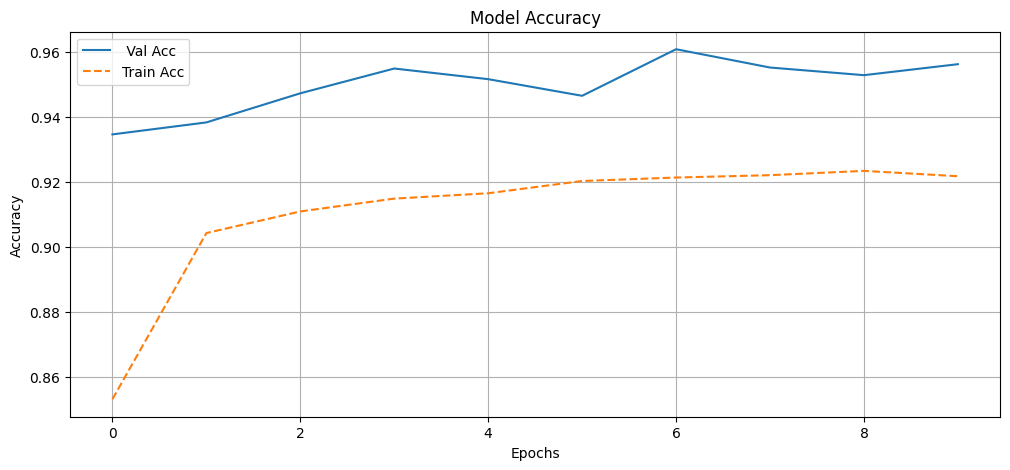

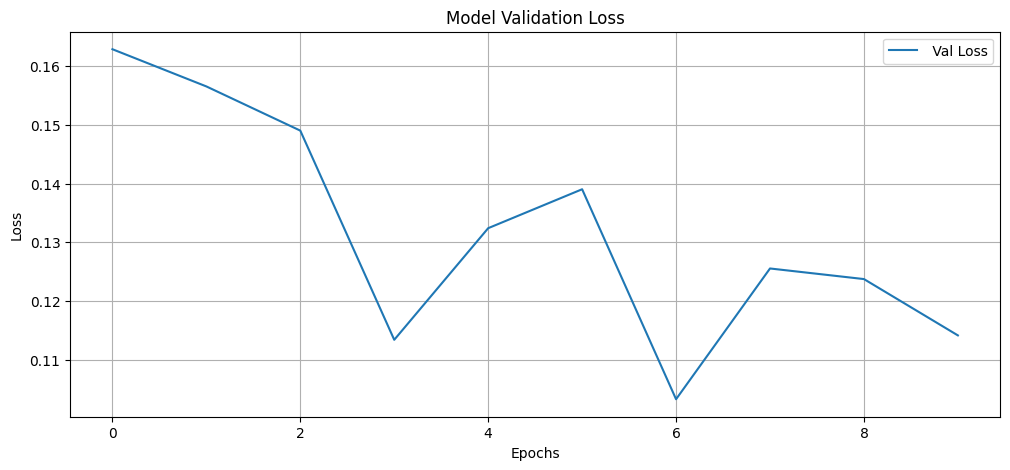

In [5]:
import matplotlib.pyplot as plt
# 畫 Accuracy
plt.figure(figsize=(12, 5))


plt.plot(history.history['val_accuracy'], label=f" Val Acc", linestyle='-')
plt.plot(history.history['accuracy'], label=f"Train Acc", linestyle='--')

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 畫 Loss
plt.figure(figsize=(12, 5))

plt.plot(history.history['val_loss'], label=f" Val Loss")

plt.title('Model Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

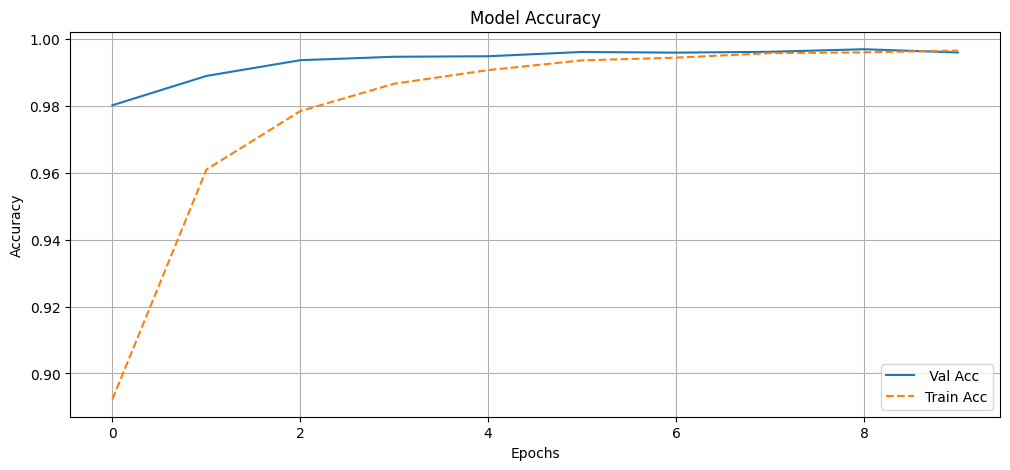

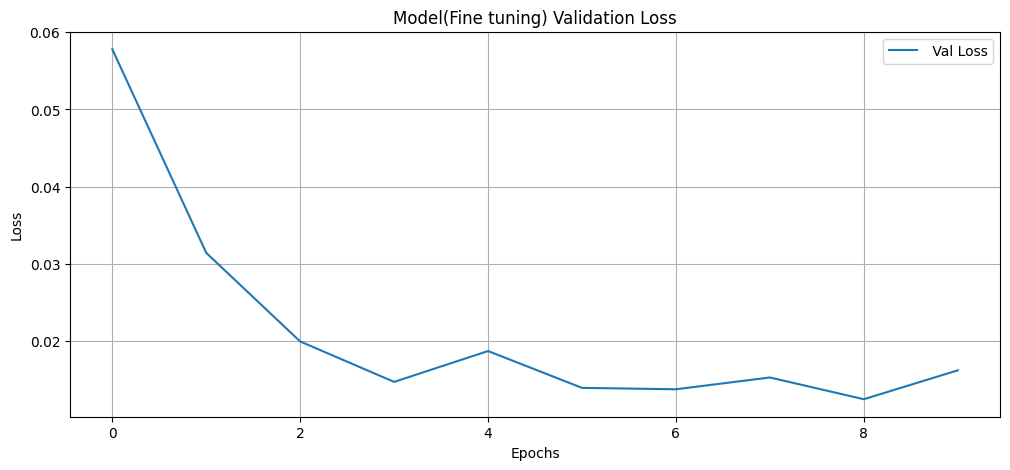

In [6]:
import matplotlib.pyplot as plt

# 畫 Accuracy
plt.figure(figsize=(12, 5))


plt.plot(history_ft.history['val_accuracy'], label=f" Val Acc", linestyle='-')
plt.plot(history_ft.history['accuracy'], label=f"Train Acc", linestyle='--')

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 畫 Loss
plt.figure(figsize=(12, 5))

plt.plot(history_ft.history['val_loss'], label=f" Val Loss")

plt.title('Model(Fine tuning) Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Generating predictions on the test dataset...


2025-12-12 22:45:53.735097: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total test samples processed: 19501

--- Key Performance Metrics ---
Overall Accuracy: 0.9968
Balanced Accuracy Score: 0.9968
-------------------------------

Classification Report (Precision, Recall, F1-Score per class):

                  precision    recall  f1-score   support

      all_benign       1.00      1.00      1.00       750
       all_early       1.00      1.00      1.00       750
         all_pre       1.00      1.00      1.00       750
         all_pro       1.00      1.00      1.00       750
    brain_glioma       1.00      1.00      1.00       750
     brain_menin       1.00      0.99      0.99       750
     brain_tumor       0.99      1.00      0.99       750
   breast_benign       1.00      0.99      1.00       750
breast_malignant       0.99      1.00      1.00       750
      cervix_dyk       1.00      1.00      1.00       750
      cervix_koc       1.00      1.00      1.00       750
      cervix_mep       1.00      1.00      1.00       750
      cervix_pab      

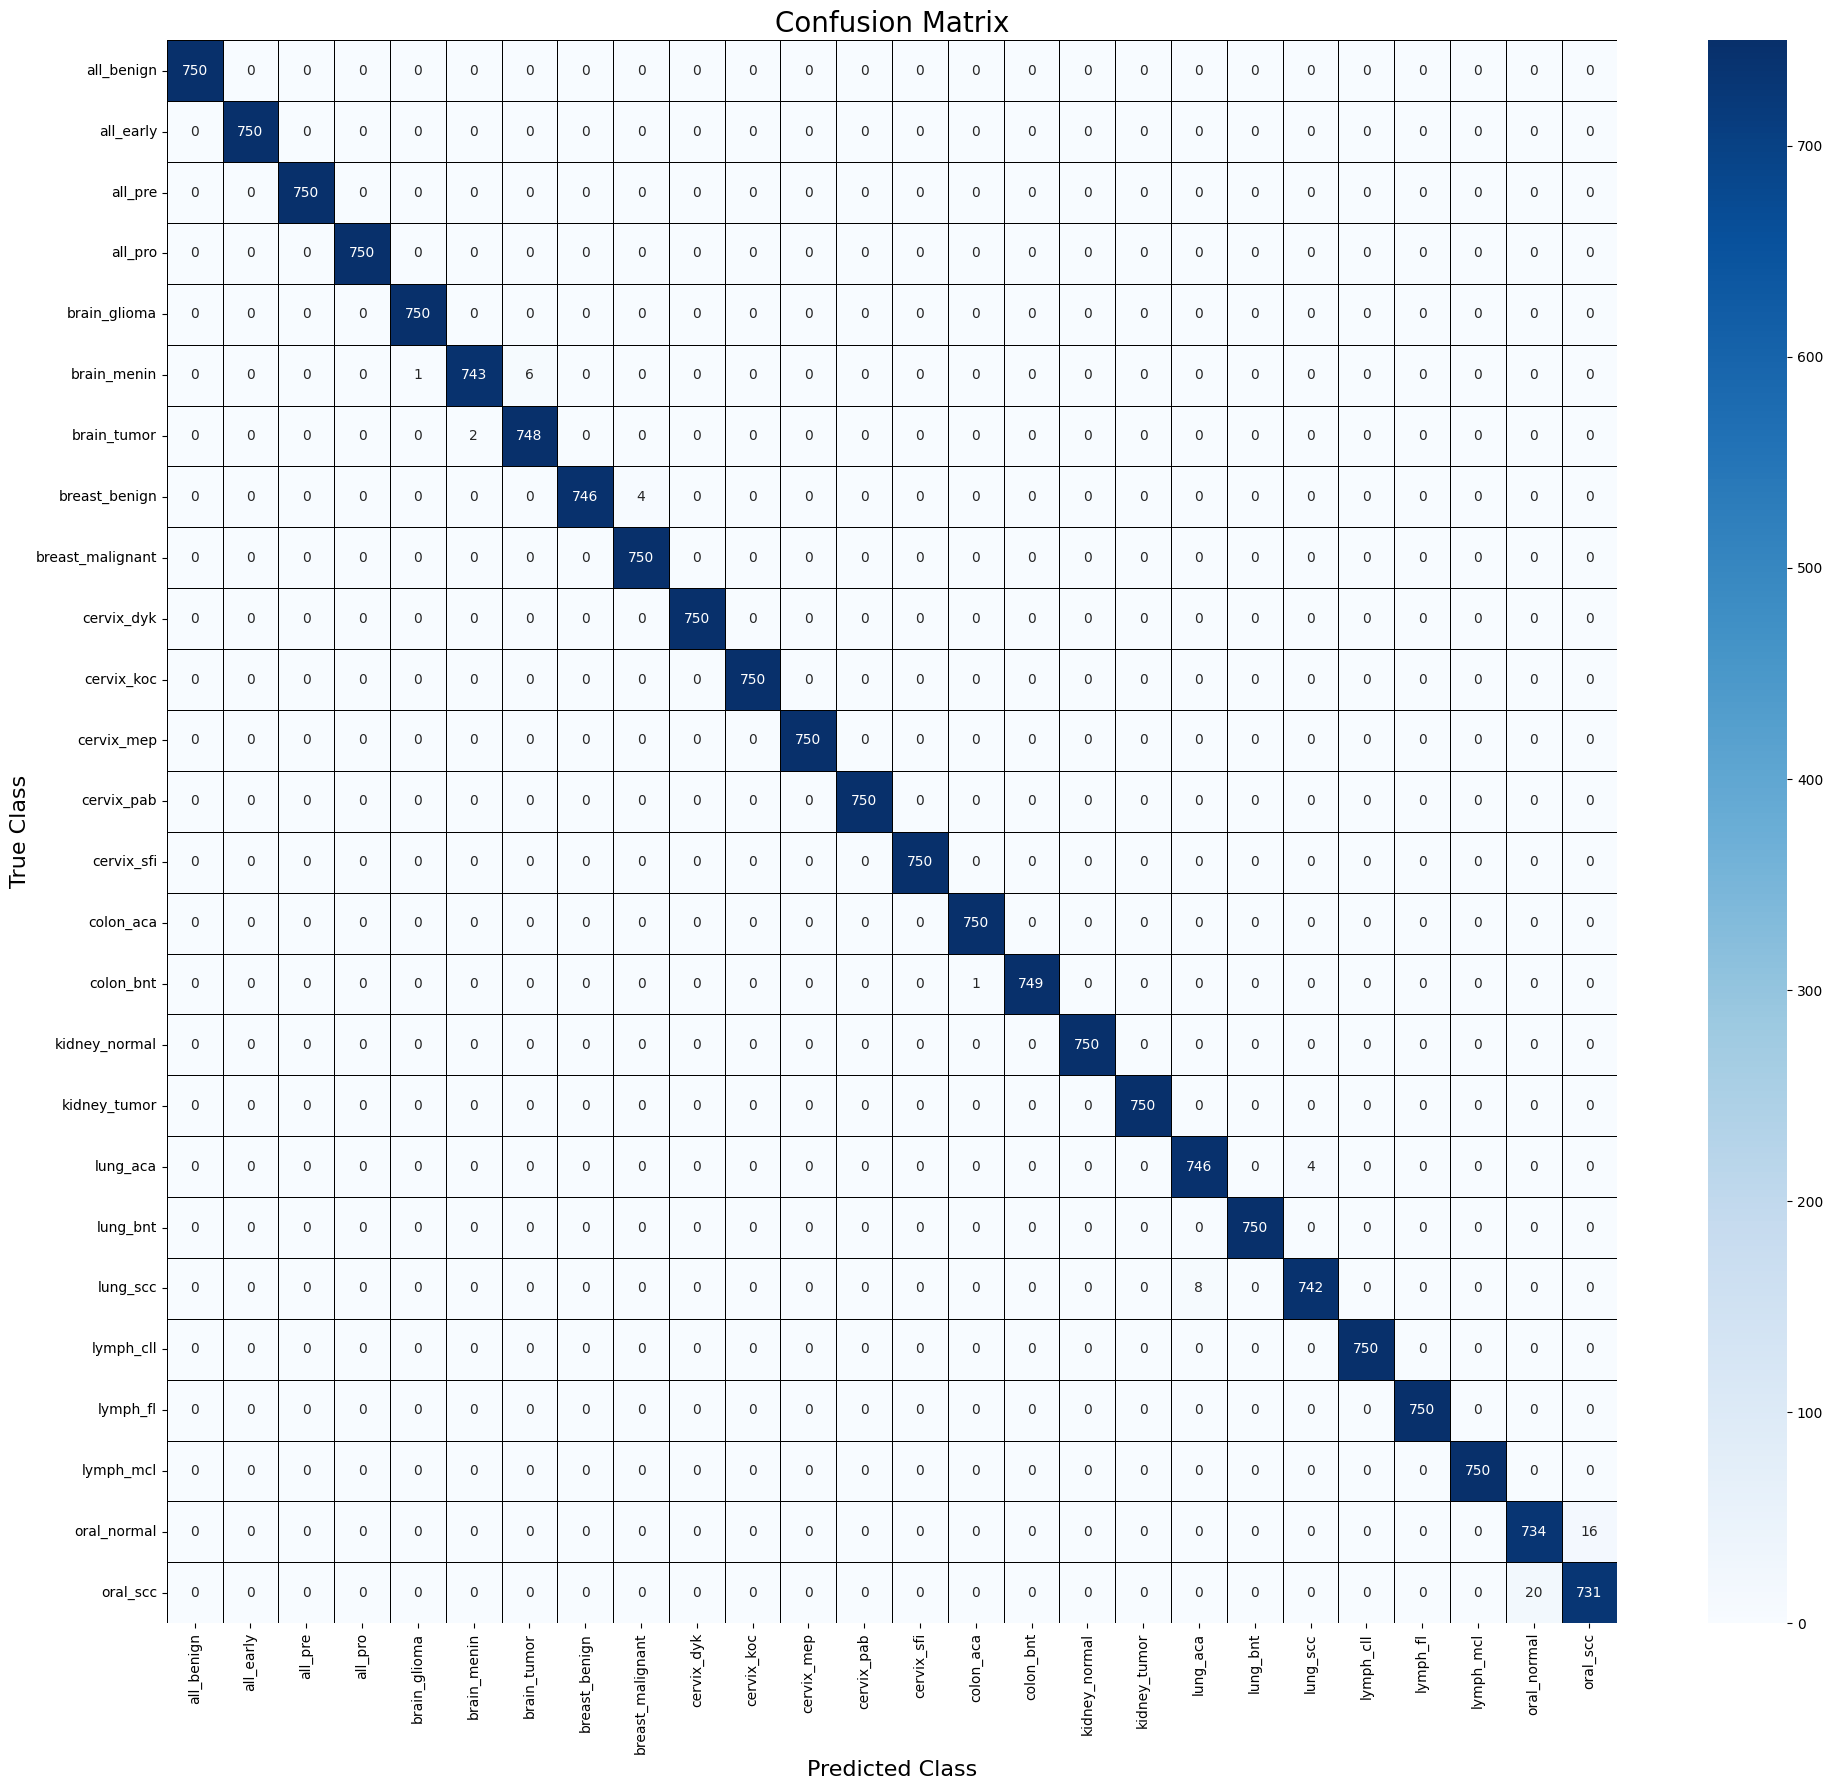

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
import seaborn as sns
from tensorflow.keras.models import load_model # Used if you saved the best model

# --- 1. Load the Best Model (if saved) ---
try:
    # Use the path to the best model saved during the fine-tuning stage
    final_model = load_model('best_multiclass_finetune.keras') 
except:
    print("Could not load saved model. Using the currently trained 'multiclass_model'.")
    final_model = multiclass_model


# --- 2. Generate Predictions on the Test Set ---
print("Generating predictions on the test dataset...")

true_labels_one_hot = []
predictions_one_hot = []

# Iterate over the test dataset
for images, labels in test_ds:
    preds = final_model.predict(images, verbose=0)
    predictions_one_hot.extend(preds)
    true_labels_one_hot.extend(labels.numpy())

# Convert from one-hot back to class indices (0 to 25)
y_true = np.argmax(true_labels_one_hot, axis=1)
y_pred = np.argmax(predictions_one_hot, axis=1)

print(f"Total test samples processed: {len(y_true)}")


# --- 3. Display Key Metrics ---

# a. Calculate overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
# b. Calculate Balanced Accuracy (better for imbalanced datasets)
balanced_acc = balanced_accuracy_score(y_true, y_pred)

print("\n--- Key Performance Metrics ---")
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Balanced Accuracy Score: {balanced_acc:.4f}")
print("-------------------------------\n")

# c. Classification Report (Precision, Recall, F1-Score per class)
report = classification_report(y_true, y_pred, target_names=index_to_class, zero_division=0)
print("Classification Report (Precision, Recall, F1-Score per class):\n")
print(report)


# --- 4. Compute and Plot the Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix (Recall)'

    plt.figure(figsize=(20, 18))
    sns.heatmap(cm, annot=True, fmt='g' if not normalize else '.2f', cmap=cmap, cbar=True,
                xticklabels=classes, yticklabels=classes, linewidths=.5, linecolor='black')
    
    # Set labels and title
    plt.title(title, fontsize=20)
    plt.ylabel('True Class', fontsize=16)
    plt.xlabel('Predicted Class', fontsize=16)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

# Plot the Normalized Matrix (shows Recall)
plot_confusion_matrix(cm, classes=index_to_class, normalize=False)

/home/haoyu/114-1_DL_final/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/tmp/ipykernel_581242/4046602763.py:59: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


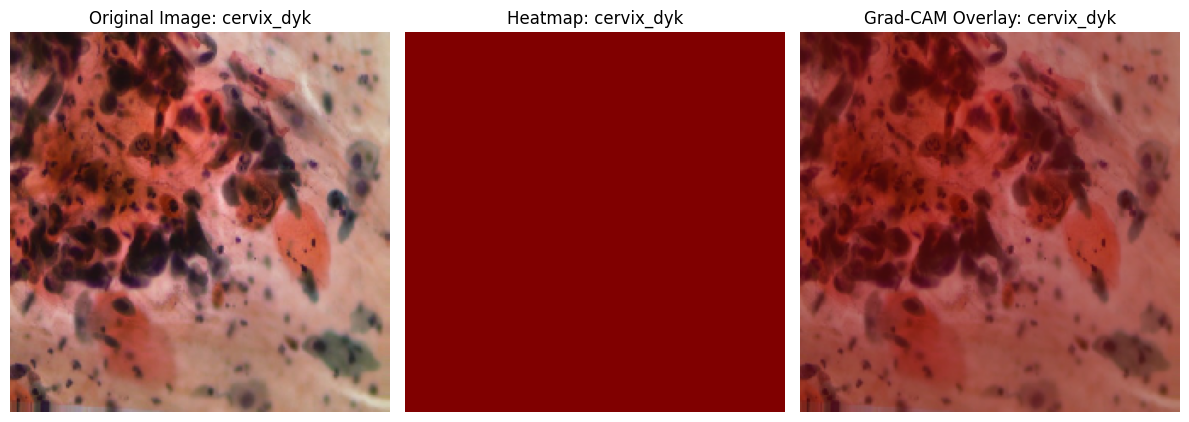

In [8]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.models import Model



# The last convolutional layer in ResNet50 before the global pooling.
LAST_CONV_LAYER_NAME = 'conv5_block3_out' 


def get_grad_cam_heatmap(img_array, model, last_conv_layer_name):
    """Generates a Grad-CAM heatmap."""
    # Create a dummy input tensor matching the expected batch shape
    #dummy_input = tf.zeros((1,) + img_array.shape) 
    
    # Call the model once with the dummy input to instantiate all layers and outputs
    #_ = model(dummy_input)
    
    # 1. Create a model mapping input to last conv layer output and final prediction
    grad_model = Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    img_tensor = tf.expand_dims(img_array, axis=0) # Add batch dimension
    
    # 2. Compute the gradient of the highest predicted class
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_tensor)
        pred_index = tf.argmax(preds[0]) # Index of the top predicted class
        class_channel = preds[:, pred_index]

    # 3. Compute gradients and pool the gradient averages
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 4. Generate the heatmap (weighted sum of feature maps)
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 5. Normalize and clip the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    max_val = tf.reduce_max(heatmap)
    epsilon = 1e-5
    heatmap = heatmap / (max_val + epsilon)
    
    return heatmap.numpy(), pred_index.numpy()

def display_gradcam(img, heatmap, pred_class_idx, alpha=0.4):
    """Overlays the heatmap onto the original image."""
    
    # Convert prediction index back to class name
    predicted_class = index_to_class[pred_class_idx]
    
    # Resize heatmap to original image dimensions
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Apply the JET color map for visualization
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Create the superimposed image
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    
    plt.figure(figsize=(12, 6))

    # 1. Original Image Plot
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original Image: {predicted_class}", fontsize=12)
    plt.axis('off')

    # 2. heatmap Plot
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title(f"Heatmap: {predicted_class}", fontsize=12)
    plt.axis('off')

    # 3. Grad-CAM Overlay Plot
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Overlay: {predicted_class}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()



# --- Example Usage ---
# NOTE: Run this cell after training is complete

# 1. Select a random image from the test set
random_idx = np.random.randint(0, len(X_test))
test_image_path = X_test[random_idx]

# 2. Load the image for display (original format)
display_img = np.array(tf.keras.utils.load_img(test_image_path, target_size=IMAGE_SIZE))

# 3. Load and preprocess the image for the model (float32, ResNet50 preproc)
img_array = tf.keras.utils.img_to_array(display_img)
img_array = preprocess_input(img_array)



# 4. Generate Heatmap and get Prediction Index
heatmap, pred_index = get_grad_cam_heatmap(img_array, final_model, LAST_CONV_LAYER_NAME)

# 5. Display Grad-CAM overlay
display_gradcam(display_img, heatmap, pred_index)